### 0. Install Dependencies

In [2]:
!sudo apt-get install libkrb5-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.17-6ubuntu4.2).
libkrb5-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
!pip install arcgis==1.8.4  torch==1.4.0  fastai==1.0.60 torchvision==0.5.0 fastprogress pandas 

In [ ]:
!pip install transformers==3.3.0

### 1. Import Dependencies

In [4]:
import os, zipfile
from pathlib import Path
from arcgis.learn import prepare_textdata
from arcgis.learn.text import SequenceToSequence

### 2. Data Preparation

In [5]:
filepath = r'/content/address_standardization_correction_data_small.zip'

In [6]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
data_root = Path(os.path.join(os.path.splitext(filepath)[0]))

In [8]:
data = prepare_textdata(path=data_root, batch_size=16, task='sequence_translation', 
                        text_columns='non-std-address', label_columns='std-address', 
                        train_file='address_standardization_correction_data_small.csv')

In [9]:
data.show_batch()

non-std-address,std-address
"407, brenfandow ct, noblesville, un, 46060.0, us","407, brendandow ct, noblesville, in, 46060.0, us"
"405, en huntington rd, andale, ks, 67001.0, us","405, n huntington rd, andale, ks, 67001.0, us"
"184, mlil st, burnt prairie, il, 62820.0, us","184, mill st, burnt prairie, il, 62820.0, us"
"12640, fairview avenue, blue island, illinois, 60406.0, us","12640, fairview avenue, blue island, il, 60406.0, us"
"6059, eest 63rd street, chicago, illinois, 60638.0, us","6059, west 63rd street, chicago, il, 60638.0, us"


### 3. SequenceToSequence model

In [10]:
SequenceToSequence.supported_backbones

['T5', 'Bart', 'Marian']

In [11]:
SequenceToSequence.available_backbone_models("T5")

['t5-small',
 't5-base',
 't5-large',
 't5-3b',
 't5-11b',
 'See all T5 models at https://huggingface.co/models?filter=t5 ']

#### 3.1 Load model architecture

In [12]:
model = SequenceToSequence(data,backbone='t5-base')

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### 3.2 Model training

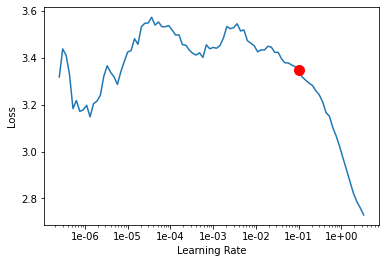

0.09999999999999999

In [13]:
lr = model.lr_find()
lr

In [14]:
model.fit(1, lr=lr)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,0.616781,0.399369,0.945831,0.884199,26:17


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [20]:
model.fit(5, lr)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.100980,0.693194,0.905270,0.817015,25:56
1,1.592410,0.959777,0.865741,0.751005,25:26
2,0.704497,0.453427,0.938502,0.872031,25:25
3,0.590160,0.390878,0.947518,0.887979,25:37
4,0.520487,0.364496,0.951211,0.894672,25:37


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### 3.2 Validate results

In [21]:
model.show_results()

text,target,pred
"30w383, ipnehurst drive, uninvorporayed/naperville, illinois, 60563.0, ud","30w383, pinehurst dr, unincorporated/naperville, il, 60563.0, us","30w383, ipnehurst dr, un, il, 60563.0, us"
"13205, suoth dotcor martin luther king jr drive, chicago, illinois, 60827.0, us","13205, south doctor martin luther king jr drive, chicago, il, 60827.0, us","13205, soth dotin luther king kr dr, chicago, il, 60827.0, us"
"1802, ewst amrtin luther king jr drive, peoria, illinois, 61602.0, us","1802, w martin luther king jr dr, peoria, il, 61602.0, us","1802, ewst mainrtin luther king kr dr, peoria, il, 61602.0, us"
"427, south mccomas srteet, wcihita, kansas, 67213.0, us","427, s mccomas st, wichita, ks, 67213.0, us","427, s mcitas srteet, wciita, ks, 67213.0, us"
"10s231, plainfield/naperolle rd, unincrporated/naperville, il, 60565.0, us","10s231, plainfield/naperville rd, unincorporated/naperville, il, 60565.0, us","10s231, plainfield/na pe rd, unincrville, il, 60565.0, us,"


#### 3.3 Model metrics

In [22]:
model.get_model_metrics()

{'seq2seq_acc': 0.9512, 'bleu': 0.8947}

#### 3.4 Saving the trained model

In [31]:
model.save('seq2seq_unfrozen8E_bleu_89')

PosixPath('models/seq2seq_unfrozen8E_bleu_89')

### 4. Model inference

In [24]:
txt=['940, north pennsylvania avneue, mason icty, iowa, 50401, us',
     '220, soyth rhodeisland aveune, mason city, iowa, 50401, us']

In [25]:
model.predict(txt, num_beams=6, max_length=50)

[('940, north pennsylvania avneue, mason icty, iowa, 50401, us',
  '940, n pennsylvania ave, mason cty, ia, 50401, us'),
 ('220, soyth rhodeisland aveune, mason city, iowa, 50401, us',
  '220, sy rhodeisland ave, mason city, ia, 50401, us')]

<span style="background-color: LightSalmon">Non-Standard</span> &rarr;  <span style="background-color: LightGreen">Standard
</span>  ,  <span style="background-color: LightCoral">Error</span> &rarr; <span style="background-color: LightGreen">Correction
</span>
* <span style="font-size:1.5em;">940, <span style="background-color: LightSalmon;">north</span> pennsylvania <span style="background-color: LightSalmon">avneue</span>, mason <span style="background-color: LightCoral">icty</span>, <span style="background-color: LightSalmon">iowa</span>, 50401, us &rarr; 940, <span style="background-color: LightGreen">n</span> pennsylvania <span style="background-color: LightGreen">ave</span>, mason <span style="background-color: LightGreen">city</span>, <span style="background-color: LightGreen">ia</span>, 50401, us</span>


* <span style="font-size:1.5em;">220, <span style="background-color: LightCoral">soyth rhodeisland</span> <span style="background-color: LightSalmon">aveune</span>, mason city, <span style="background-color: LightSalmon">iowa</span>, 50401, us &rarr; 220, <span style="background-color: LightGreen">s rhode island ave</span>, mason city, <span style="background-color: LightGreen">ia</span>, 50401, us</span>

### 5. Zip Folder and Download

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r '/content/models.zip' '/content/models'

### 6. Convert the model into pickle file

In [28]:
import pickle

In [ ]:
with open('seq2seq_unfrozen8E_bleu_89.pkl', 'wb') as f:
  pickle.dump(models, f)